# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

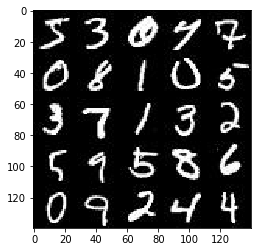

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

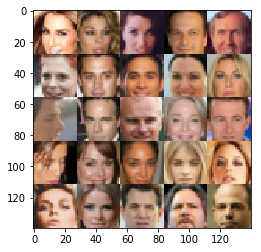

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [24]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None,image_width,image_height,image_channels), name='real_input') 
    z_input = tf.placeholder(tf.float32, (None,z_dim), name='z_input') 
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [15]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 128, 5, 
                              strides=2, 
                              kernel_initializer = tf.random_normal_initializer(stddev=0.01),
                              padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 256, 5, 
                              strides=2, 
                              kernel_initializer = tf.random_normal_initializer(stddev=0.01),
                              padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 512, 5, 
                              strides=1, 
                              kernel_initializer = tf.random_normal_initializer(stddev=0.01),
                              padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, 
                                        kernel_initializer = tf.random_normal_initializer(stddev=0.01),
                                        padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, 
                                        kernel_initializer = tf.random_normal_initializer(stddev=0.01),
                                        padding='same')
        
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 
                                            strides=1, 
                                            kernel_initializer = tf.random_normal_initializer(stddev=0.01),
                                            padding='same')
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim,alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake;
    g_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update = [opt for opt in update_ops if opt.name.startswith('generator')]
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps = 0
    print_every = 20
    show_every = 100
        
    width = data_shape[1]
    height = data_shape[2]
    channels = data_shape[3]
    
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, 
                             feed_dict={input_real: images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, 
                             feed_dict={input_z: batch_z, lr: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9839... Generator Loss: 7.0431
Epoch 1/2... Discriminator Loss: 1.4911... Generator Loss: 0.6420
Epoch 1/2... Discriminator Loss: 2.2509... Generator Loss: 3.5695
Epoch 1/2... Discriminator Loss: 1.7352... Generator Loss: 0.9027
Epoch 1/2... Discriminator Loss: 0.9690... Generator Loss: 4.0335


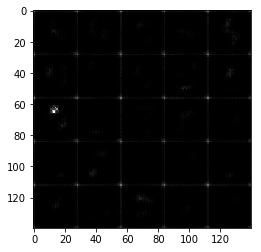

Epoch 1/2... Discriminator Loss: 2.4399... Generator Loss: 4.4335
Epoch 1/2... Discriminator Loss: 1.2392... Generator Loss: 0.9038
Epoch 1/2... Discriminator Loss: 2.9207... Generator Loss: 0.1678
Epoch 1/2... Discriminator Loss: 1.3441... Generator Loss: 0.8214
Epoch 1/2... Discriminator Loss: 1.8056... Generator Loss: 3.2922


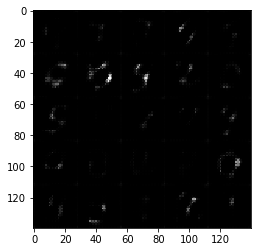

Epoch 1/2... Discriminator Loss: 1.8521... Generator Loss: 2.4776
Epoch 1/2... Discriminator Loss: 2.9251... Generator Loss: 0.2395
Epoch 1/2... Discriminator Loss: 1.3670... Generator Loss: 1.6017
Epoch 1/2... Discriminator Loss: 1.8980... Generator Loss: 2.8719
Epoch 1/2... Discriminator Loss: 1.0281... Generator Loss: 1.3146


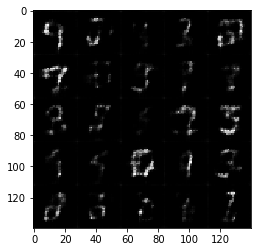

Epoch 1/2... Discriminator Loss: 1.4139... Generator Loss: 1.4222
Epoch 1/2... Discriminator Loss: 1.1612... Generator Loss: 1.3947
Epoch 1/2... Discriminator Loss: 1.0952... Generator Loss: 1.2845
Epoch 1/2... Discriminator Loss: 1.9375... Generator Loss: 0.3602
Epoch 1/2... Discriminator Loss: 1.7151... Generator Loss: 2.6794


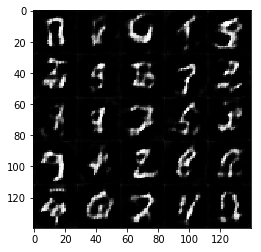

Epoch 1/2... Discriminator Loss: 1.6996... Generator Loss: 1.4706
Epoch 1/2... Discriminator Loss: 1.1753... Generator Loss: 1.8444
Epoch 1/2... Discriminator Loss: 1.6740... Generator Loss: 0.6006
Epoch 1/2... Discriminator Loss: 1.3977... Generator Loss: 2.2368
Epoch 1/2... Discriminator Loss: 1.6708... Generator Loss: 2.2537


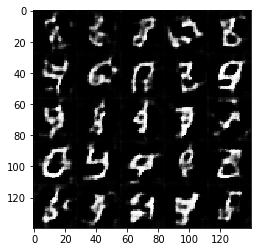

Epoch 1/2... Discriminator Loss: 1.4174... Generator Loss: 3.2689
Epoch 1/2... Discriminator Loss: 1.1265... Generator Loss: 1.4144
Epoch 1/2... Discriminator Loss: 0.8992... Generator Loss: 1.8890
Epoch 1/2... Discriminator Loss: 1.4348... Generator Loss: 0.4914
Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 2.2624


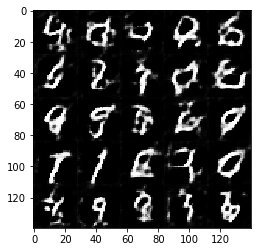

Epoch 1/2... Discriminator Loss: 1.6058... Generator Loss: 2.0175
Epoch 1/2... Discriminator Loss: 1.2097... Generator Loss: 0.7556
Epoch 1/2... Discriminator Loss: 1.7031... Generator Loss: 0.4488
Epoch 1/2... Discriminator Loss: 1.1911... Generator Loss: 1.0784
Epoch 1/2... Discriminator Loss: 1.3073... Generator Loss: 1.1287


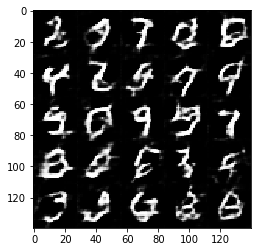

Epoch 1/2... Discriminator Loss: 1.1987... Generator Loss: 0.8236
Epoch 1/2... Discriminator Loss: 1.0685... Generator Loss: 1.6919
Epoch 1/2... Discriminator Loss: 0.8964... Generator Loss: 1.4969
Epoch 1/2... Discriminator Loss: 1.0399... Generator Loss: 1.5784
Epoch 1/2... Discriminator Loss: 1.2377... Generator Loss: 0.9306


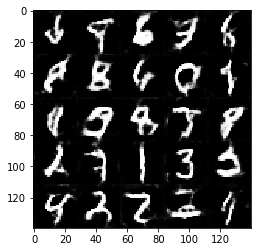

Epoch 1/2... Discriminator Loss: 1.6050... Generator Loss: 2.0164
Epoch 1/2... Discriminator Loss: 1.6894... Generator Loss: 0.5953
Epoch 1/2... Discriminator Loss: 2.3411... Generator Loss: 0.5746
Epoch 1/2... Discriminator Loss: 1.2844... Generator Loss: 1.3144
Epoch 1/2... Discriminator Loss: 1.0551... Generator Loss: 1.4733


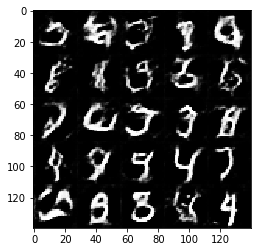

Epoch 1/2... Discriminator Loss: 2.0049... Generator Loss: 0.2915
Epoch 2/2... Discriminator Loss: 1.0633... Generator Loss: 1.5673
Epoch 2/2... Discriminator Loss: 1.0566... Generator Loss: 1.0999
Epoch 2/2... Discriminator Loss: 2.1213... Generator Loss: 0.2663
Epoch 2/2... Discriminator Loss: 1.4360... Generator Loss: 0.6728


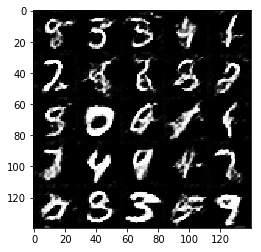

Epoch 2/2... Discriminator Loss: 1.0570... Generator Loss: 1.1647
Epoch 2/2... Discriminator Loss: 1.4303... Generator Loss: 0.5923
Epoch 2/2... Discriminator Loss: 1.2224... Generator Loss: 0.7923
Epoch 2/2... Discriminator Loss: 1.4619... Generator Loss: 0.5479
Epoch 2/2... Discriminator Loss: 1.0393... Generator Loss: 1.1104


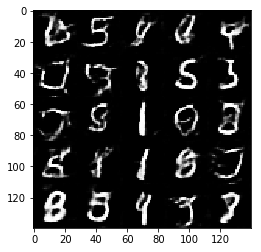

Epoch 2/2... Discriminator Loss: 1.1787... Generator Loss: 0.7674
Epoch 2/2... Discriminator Loss: 1.4392... Generator Loss: 0.5873
Epoch 2/2... Discriminator Loss: 1.2740... Generator Loss: 1.1067
Epoch 2/2... Discriminator Loss: 1.7144... Generator Loss: 0.4255
Epoch 2/2... Discriminator Loss: 1.1050... Generator Loss: 0.8052


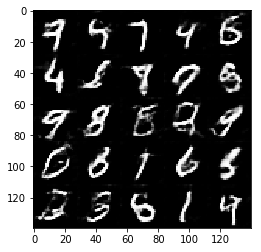

Epoch 2/2... Discriminator Loss: 1.6592... Generator Loss: 2.6709
Epoch 2/2... Discriminator Loss: 1.0488... Generator Loss: 1.1581
Epoch 2/2... Discriminator Loss: 1.3311... Generator Loss: 2.2676
Epoch 2/2... Discriminator Loss: 1.6090... Generator Loss: 0.5045
Epoch 2/2... Discriminator Loss: 1.4932... Generator Loss: 2.1927


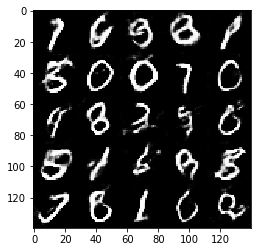

Epoch 2/2... Discriminator Loss: 1.1375... Generator Loss: 1.5963
Epoch 2/2... Discriminator Loss: 1.2271... Generator Loss: 1.6039
Epoch 2/2... Discriminator Loss: 1.3144... Generator Loss: 0.7617
Epoch 2/2... Discriminator Loss: 1.1802... Generator Loss: 1.7900
Epoch 2/2... Discriminator Loss: 1.8644... Generator Loss: 2.8227


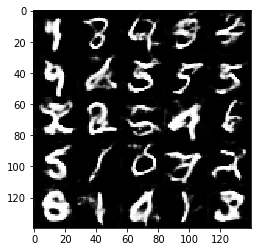

Epoch 2/2... Discriminator Loss: 1.8133... Generator Loss: 2.4797
Epoch 2/2... Discriminator Loss: 1.1075... Generator Loss: 1.0460
Epoch 2/2... Discriminator Loss: 1.1082... Generator Loss: 0.9880
Epoch 2/2... Discriminator Loss: 1.4492... Generator Loss: 1.9802
Epoch 2/2... Discriminator Loss: 1.0863... Generator Loss: 1.0078


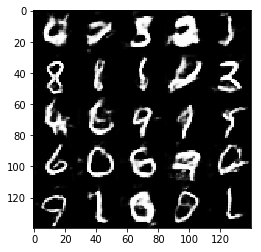

Epoch 2/2... Discriminator Loss: 1.1184... Generator Loss: 1.8049
Epoch 2/2... Discriminator Loss: 1.2451... Generator Loss: 2.0436
Epoch 2/2... Discriminator Loss: 1.6515... Generator Loss: 0.5064
Epoch 2/2... Discriminator Loss: 1.3504... Generator Loss: 2.3344
Epoch 2/2... Discriminator Loss: 1.3478... Generator Loss: 0.7205


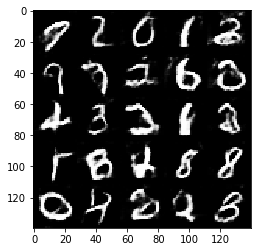

Epoch 2/2... Discriminator Loss: 1.3788... Generator Loss: 2.1293
Epoch 2/2... Discriminator Loss: 1.0628... Generator Loss: 1.3230
Epoch 2/2... Discriminator Loss: 0.9752... Generator Loss: 1.7286
Epoch 2/2... Discriminator Loss: 1.3098... Generator Loss: 0.6034
Epoch 2/2... Discriminator Loss: 1.1086... Generator Loss: 1.2369


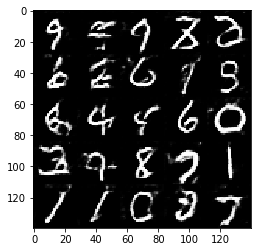

Epoch 2/2... Discriminator Loss: 1.3929... Generator Loss: 1.8627
Epoch 2/2... Discriminator Loss: 1.1113... Generator Loss: 1.0573
Epoch 2/2... Discriminator Loss: 1.3803... Generator Loss: 0.6123
Epoch 2/2... Discriminator Loss: 2.1648... Generator Loss: 0.3312
Epoch 2/2... Discriminator Loss: 1.2684... Generator Loss: 0.8308


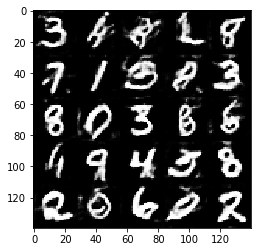

Epoch 2/2... Discriminator Loss: 1.1789... Generator Loss: 1.6355
Epoch 2/2... Discriminator Loss: 1.1383... Generator Loss: 1.0478
Epoch 2/2... Discriminator Loss: 1.0815... Generator Loss: 1.5819


In [26]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 2.6350
Epoch 1/1... Discriminator Loss: 3.1487... Generator Loss: 5.5654
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 1.1071
Epoch 1/1... Discriminator Loss: 1.9146... Generator Loss: 3.1047
Epoch 1/1... Discriminator Loss: 2.2307... Generator Loss: 0.2854


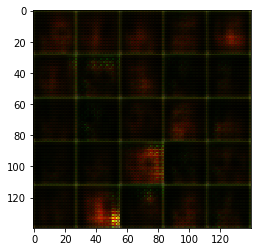

Epoch 1/1... Discriminator Loss: 0.4404... Generator Loss: 3.0618
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 2.6394
Epoch 1/1... Discriminator Loss: 2.5555... Generator Loss: 0.5153
Epoch 1/1... Discriminator Loss: 1.8204... Generator Loss: 0.3716
Epoch 1/1... Discriminator Loss: 1.8355... Generator Loss: 2.3112


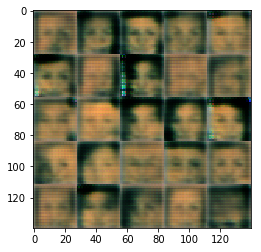

Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 1.8530
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 1.4668
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 0.8787


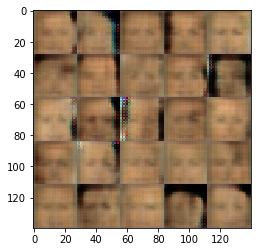

Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 1.1171
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.4948
Epoch 1/1... Discriminator Loss: 1.6841... Generator Loss: 0.4744
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 1.7312
Epoch 1/1... Discriminator Loss: 1.7872... Generator Loss: 0.3304


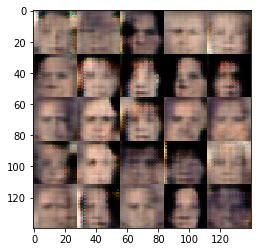

Epoch 1/1... Discriminator Loss: 1.5530... Generator Loss: 1.3546
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 1.2662
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.5911... Generator Loss: 1.2849
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 1.0657


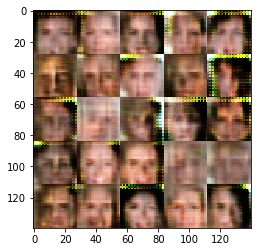

Epoch 1/1... Discriminator Loss: 1.6775... Generator Loss: 0.4027
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 1.2997
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.9801
Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 2.0986... Generator Loss: 0.2731


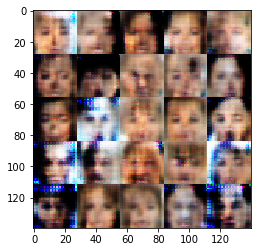

Epoch 1/1... Discriminator Loss: 1.6321... Generator Loss: 1.1305
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 1.5234
Epoch 1/1... Discriminator Loss: 2.6928... Generator Loss: 3.8410
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7492


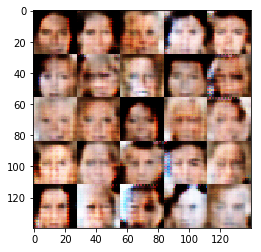

Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 1.3087
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 1.6358... Generator Loss: 1.5418
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.6835


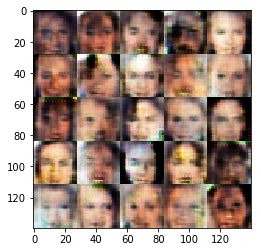

Epoch 1/1... Discriminator Loss: 1.6042... Generator Loss: 1.8959
Epoch 1/1... Discriminator Loss: 1.5575... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 1.2003


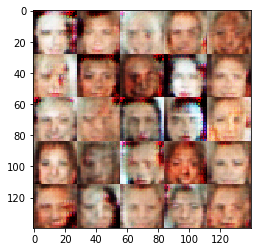

Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.5588... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.8580... Generator Loss: 0.3294
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.9771


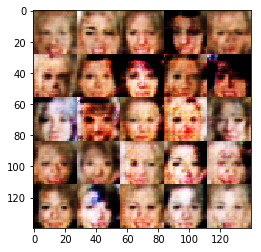

Epoch 1/1... Discriminator Loss: 1.5797... Generator Loss: 0.4916
Epoch 1/1... Discriminator Loss: 1.5867... Generator Loss: 0.5688
Epoch 1/1... Discriminator Loss: 1.5346... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.6409


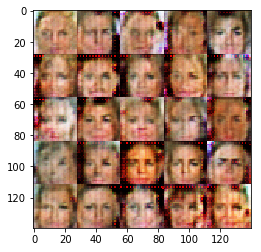

Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 1.4043
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 1.0348
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.9557


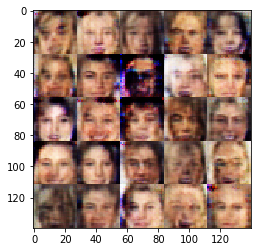

Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 1.6356... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 1.0193


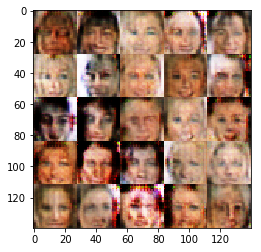

Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.9423
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.9358


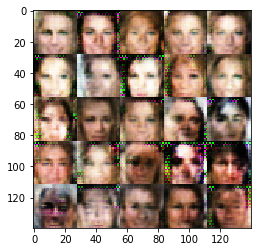

Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.7271


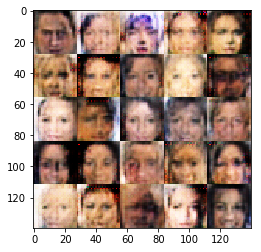

Epoch 1/1... Discriminator Loss: 1.7409... Generator Loss: 1.6239
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 1.0055
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.8180


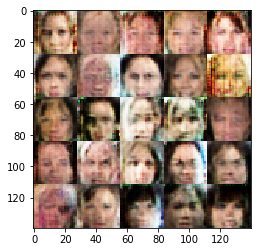

Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 1.4280
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 1.7616


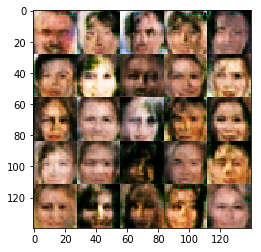

Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 1.0080


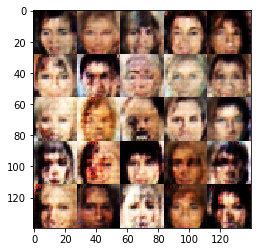

Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.8480


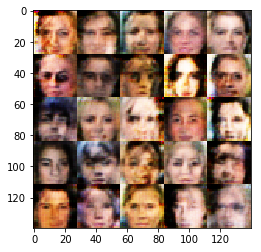

Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.5338
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 1.1065


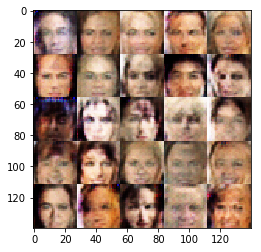

Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.8130... Generator Loss: 1.1782
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 1.0041


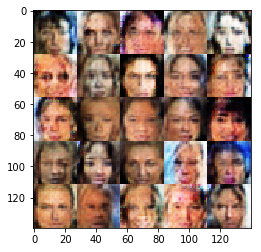

Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 2.2444... Generator Loss: 2.0913
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.9598


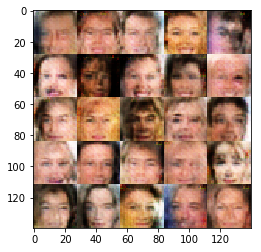

Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.9546
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.7413


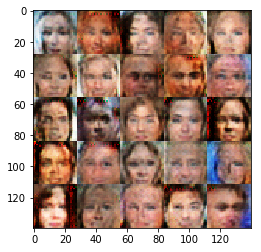

Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 1.0425
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 1.3360


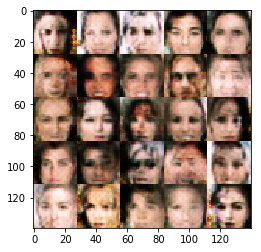

Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.9876
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.7679


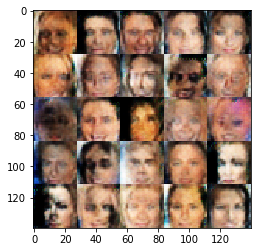

Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 1.0010
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7480


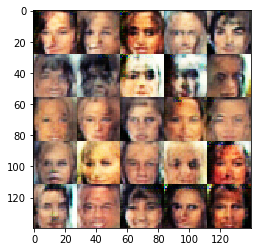

Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.9644
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.6959


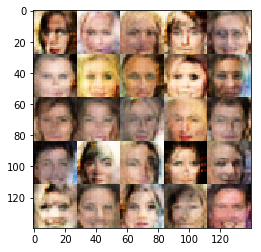

Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.9833
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7004


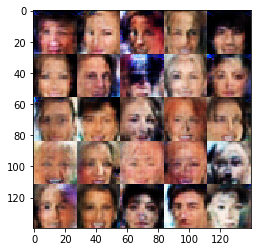

Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.8906


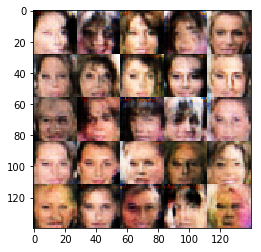

Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7189


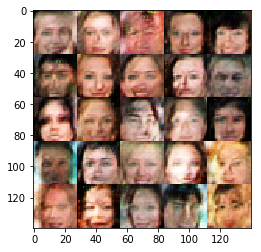

Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 1.2834
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7303


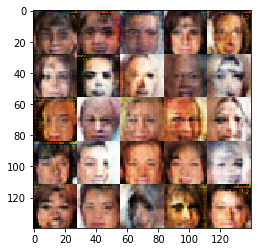

Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7330


In [27]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.